In [30]:
import geopandas as gpd
import numpy as np
from shapely import geometry
from shapely.affinity import rotate
from shapely.affinity import scale
from shapely.affinity import translate
from collections import OrderedDict
from IPython.core.display import HTML
import os
%matplotlib inline

In [40]:
## parameter settings
# geometry_file = r"D:\Projects\Pr\3723.10\Werkfolder\catchments_raw.shp"
# svg_file = 'catchments_icons.txt'
# key_column = 'catchment_'

geometry_file = r"D:\Projects\Pr\3723.10\Werkfolder\ecowas_countries_WGS84.shp"
svg_file = 'country_icons.txt'
key_column = 'COUNTRY'

folder_svg = r'T:\@niels\svg'
svg_width = 18
svg_height = 18
strokeWidth = 2

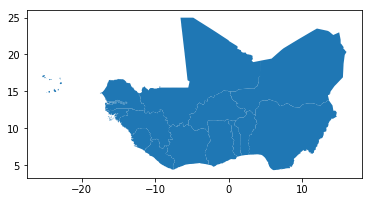

In [41]:
gdf = gpd.read_file(geometry_file)
# only select geometries that are not none
gdf = gdf[~gdf['geometry'].isnull()]
gdf.plot()

In [42]:
gdf.tail()

,ID,CODE,COUNTRY,MERGEFIELD,geometry
108,391,GUB,Guinea-Bissau,1,POLYGON ((-16.14779099999578 11.36626999999862...
112,393,GUB,Guinea-Bissau,1,POLYGON ((-16.00370999998995 11.52159999999276...
114,394,GUB,Guinea-Bissau,1,"POLYGON ((-16.4816400000127 11.27659999999742,..."
166,446,LIB,Liberia,1,"POLYGON ((-11.4591700000019 6.929609999999229,..."
167,754,TOG,Togo,1,"POLYGON ((0.613510000000133 7.920639999996638,..."


In [43]:
# sometimes are multiple row items for the same feature 
# disssolve features into multipolygon
gdf_dis = gdf.dissolve(key_column)

In [44]:
# from Polygon to LineString
for idx, row in gdf_dis.iterrows():
    geom = row['geometry']
    gdf_dis.at[idx, 'geometry'] = geom.boundary

In [45]:
gdf_dis.head()

,geometry,ID,COUNTRY,MERGEFIELD
CODE,,,,
BEN,LINESTRING (2.405399999999645 11.9016100000008...,20,Benin,1
BUF,LINESTRING (0.2293500000000677 14.989669999995...,22,Burkina Faso,1
CAP,(LINESTRING (-24.68150299999979 14.83656199999...,27,Cape Verde,1
CDI,LINESTRING (-5.518920000002254 10.433260000005...,49,Cote d`Ivoire,1
GAM,(LINESTRING (-16.62441099999705 13.42024999999...,318,Gambia,1


In [46]:
def scale_locate_geom(geom, xmax, ymin, factor):
    x1, y1 = geom.xy
    round_vl = 3
    x1_round = (np.round(np.array(x1), round_vl) - xmax ) * factor
    y1_round = (np.round(np.array(y1), round_vl) - ymin ) * factor

    coords_round = list(zip(np.array(x1_round), np.array(y1_round)))
    unique_coords_round = OrderedDict.fromkeys(coords_round).keys() 

    geom = geometry.LinearRing(list(unique_coords_round)) 
    return geom

In [47]:
new_dict = {}
for idx, row in gdf_dis.iterrows():
    idx = row.name
    print(idx)
    
    # simplify geometry
    smp_geom = row['geometry'].simplify(0.1)
    xmin, ymin, xmax, ymax = row['geometry'].bounds

    # set factors for resizing
    factor_y = svg_height / (ymax-ymin)
    factor_x = svg_width / (xmax-xmin)

    if factor_y >= factor_x:
        factor = factor_x
    else:
        factor = factor_y
    
    # relocate and resize geometries
    if smp_geom.type == 'LineString':
        smp_gm = scale_locate_geom(smp_geom, xmax, ymin, factor)        
        
    if smp_geom.type == 'MultiLineString':
        new_geom = []
        for line in smp_geom:
            ring = scale_locate_geom(line, xmax, ymin, factor)      
            new_geom.append(ring)
            
        smp_gm = geometry.MultiLineString(new_geom)
    
    # rotate and flip
    smp_gm = rotate(smp_gm, 180)
    smp_gm = scale(smp_gm, xfact = -1, origin = (1, 0))
    
    # place geom in middle of dom
    xmin, ymin, xmax, ymax = smp_gm.bounds
    xoff = ((svg_width + strokeWidth * 2) / 2) - (np.round(xmax-xmin) / 2) + 1
    yoff = ((svg_height + strokeWidth * 2) / 2) - (np.round(ymax-ymin) / 2) + 1
    print(xoff, yoff)
    smp_mv_gm = translate(smp_gm, xoff, yoff)    

    # convert to svg and change styling
    item_svg = smp_mv_gm.svg()
    item_svg = item_svg.replace('stroke="#66cc99" stroke-width="2.0"', 'stroke="#BDBDBD" stroke-width="2.0"')
    item_svg = item_svg.replace(' opacity="0.8" ', '')    
    item_svg = item_svg.replace('<g>', "")
    item_svg = item_svg.replace('</g>', "")      
    
#     onmouseover="evt.target.setAttribute('fill', '#2196F3');" onmouseout="evt.target.setAttribute('fill', 'none');"')""")
#     item_svg = item_svg.replace('<polyline fill="none" stroke="#66cc99" stroke-width="2.0" ', '<polyline ') 
#     item_svg = item_svg.replace('<polyline fill="none" stroke="#66cc99" stroke-width="2.0" ', '"polyline",{ ')
#     item_svg = item_svg.replace(' opacity="0.8" ', '')
#     item_svg = item_svg.replace('/>', '}')
#     item_svg = item_svg.replace('points=', 'points: points=')
#     item_svg = item_svg.replace('"}"polyline"', '}, "polyline"')
#     item_svg = item_svg.replace('<g>', "[")
#     item_svg = item_svg.replace('</g>', "]")    
    new_dict.update({idx: item_svg})
    display(HTML(''' 
        <svg> 
        {}
        </svg >'''.format(item_svg)))    

BEN
7.5 3.0


BUF
3.0 5.5


CAP
3.0 4.0


CDI
3.5 3.0


GAM
3.0 9.5


GHA
6.0 3.0


GIN
3.0 5.5


GUB
3.0 7.0


LIB
3.0 3.0


MAL
3.0 4.0


NIG
3.0 5.5


NIR
3.0 5.0


SEN
3.0 5.5


SIL
3.0 3.0


TOG
8.5 3.0


In [48]:
keys = new_dict.keys()
with open(os.path.join(folder_svg, svg_file), 'w') as f:
    for key in keys:
        f.write('{}: \n{}\n\n'.format(key, new_dict[key]))